In [2]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from timerun import time_code, time_func
import time
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from parallel_methods import DSMethods
from sklearn.utils import resample
import math
import pandas as pd
from sklearn import preprocessing
import pickle

In [3]:
def plot_train_vs_test(train_scores, test_scores, spoint = None, wo = None, points = {}, time = -1, tvar = -1):
    if points != {}: plt.scatter(points.keys(), points.values(), marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    
    xleft, xright = plt.xlim()
    if spoint and wo:
        plt.scatter(spoint[0], spoint[1], s=10, c='red')
        w = [-wo[1]/n_features, wo[0]]
        b = w[0]*spoint[0] + w[1]*spoint[1]
        xleft, xright = plt.xlim()
        xd = np.array([xleft, xright])
        yd = [(b - w[0]*xd[0]) / w[1], (b - w[0]*xd[1]) / w[1]]
        plt.plot(xd, yd, lw=1, c='red')
    
    plt.legend()
    plt.ylim([0.4,1.0])
    plt.xlim([xleft, xright])
    plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")

    plt.show()

    print("AT", spoint, "WITH", len(points), "ITERATIONS IN", time, "SECONDS :", tvar)

def scal(data, w):
    obj = np.array([w[0] * (1 - acc) + w[1] * (i / n_features) for i, acc in data.items()])
    spoint_x = list(data.keys())[np.argmin(obj)]
    spoint_y = data[spoint_x]
    return (spoint_x, spoint_y, obj[np.argmin(obj)])

def mean_of_arrays(data):
    arr = {}
    for x in data[0]:
        arr[x] = np.mean([data[v][x] for v in data])
    return arr

In [4]:
n_features = 500

# Load the madelon training dataset
train_data = pd.read_table("MADELON/madelon_train.data", sep=' ', header=None, usecols=range(0,500))
train_labels = pd.read_table("MADELON/madelon_train.labels", sep=' ', header=None)
X_train, X_test = np.split(preprocessing.scale(train_data.to_numpy()), [1200])
y_train, y_test = np.split(np.ravel(train_labels.to_numpy()), [1200])

data = DSMethods(n_features, X_train, y_train, X_test, y_test)

# Random selection

In [5]:
@time_func
def RANDOM_SELECTION(CVal = 0.1, kernel='liblinear', w1 = [0.8, 0.2]):
    data.kernel = kernel
    data.C = CVal
    with Pool(7) as pool:
        scores = pool.map(data.randomSelection, [CVal]*10)
    
    #scores = list(map(data.randomSelection, [0.1]))

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    time         = np.mean([x[2] for x in scores])
    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1)

In [6]:
#RANDOM_SELECTION(0.00001)

In [7]:
X_train, X_test = np.split(preprocessing.scale(train_data.to_numpy()), [2000])
y_train, y_test = np.split(np.ravel(train_labels.to_numpy()), [2000])

# SVM-RFE

In [8]:
@time_func
def SVM_RFE_W_STEP(mode='kernel', step = 20, percentage = 0.5, C = 0.5, kernel = 'liblinear', prekernel='precomputed', w1 = [0.8, 0.2], gamma = 1.0, degree=6):
    data.kernel = prekernel
    data.kernel_matrix = kernel
    data.C = C
    data.gamma = gamma
    data.degree = degree
    kf = KFold(n_splits=7, shuffle=True)

    if mode == 'kernel':
        index = [(train_index, test_index, step) for train_index, test_index in kf.split(data.X_train)]
        with Pool(7) as pool:
            scores = pool.map(data.svm_rfe_kernel, index)
    if mode == 'linear':
        index = [(train_index, test_index, step) for train_index, test_index in kf.split(data.X_train)]
        with Pool(7) as pool:
            scores = pool.map(data.svm_rfe, index)

    #scores = list(map(data.svm_rfe_kernel, index))
    scores = list(scores)

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])
    tvar         = np.var([x[3] for x in scores])

    tvar         = np.var([x[3] for x in scores])

    all_scores = [scal(x[1], w1)[2] for x in scores]
    err = np.std(all_scores, ddof=1) / np.sqrt(np.size(all_scores))

    print(kernel, C, degree, gamma)
    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1, points, time, tvar)
    return scal(test_scores, w1), time, (np.mean(all_scores), err)

poly 0.1 1 1.0


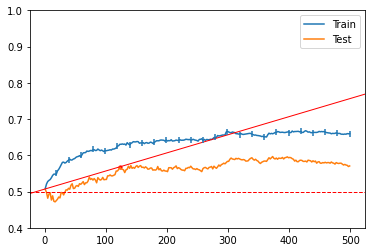

AT (123, 0.5682665967243691, 0.39458672262050476) WITH 25 ITERATIONS IN 127.89504504203796 SECONDS : 59.64132103040237
__main__.SVM_RFE_W_STEP - 00:02:30.524696700
poly 0.2 1 1.0


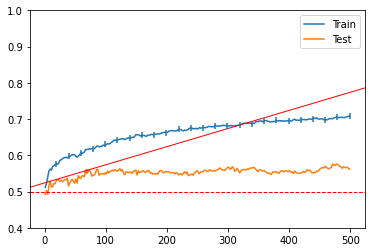

AT (67, 0.5574789687396787, 0.38081682500825703) WITH 25 ITERATIONS IN 130.6084963253566 SECONDS : 72.69678302701429
__main__.SVM_RFE_W_STEP - 00:02:33.489158600
poly 0.3 1 1.0


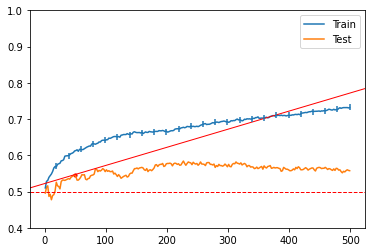

AT (49, 0.5466233412989839, 0.38230132696081287) WITH 25 ITERATIONS IN 127.25752936090741 SECONDS : 64.16655648273888
__main__.SVM_RFE_W_STEP - 00:02:30.278480100
poly 0.4 1 1.0


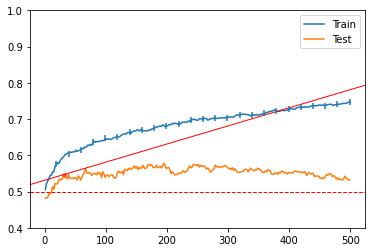

AT (31, 0.5466913407549883, 0.3750469273960094) WITH 25 ITERATIONS IN 124.60699268749782 SECONDS : 66.74743853208759
__main__.SVM_RFE_W_STEP - 00:02:27.698737700
poly 0.5 1 1.0


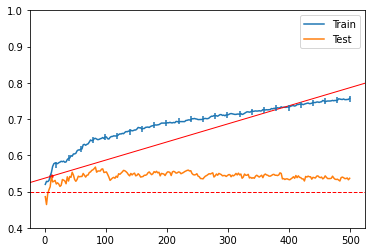

AT (11, 0.5424122321307143, 0.3704702142954286) WITH 25 ITERATIONS IN 122.99048614501953 SECONDS : 54.227505702280105
__main__.SVM_RFE_W_STEP - 00:02:26.437443800
poly 0.6 1 1.0


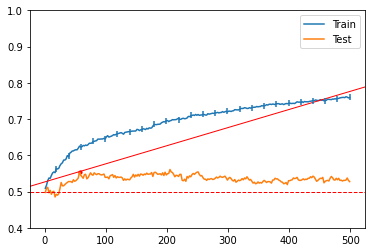

AT (57, 0.5550552738435235, 0.3787557809251812) WITH 25 ITERATIONS IN 124.20635332380023 SECONDS : 71.11465486778907
__main__.SVM_RFE_W_STEP - 00:02:27.998157100
poly 0.7 1 1.0


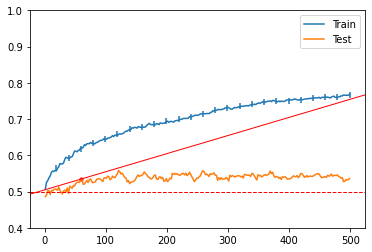

AT (59, 0.5341988692661886, 0.39624090458704914) WITH 25 ITERATIONS IN 125.9471493107932 SECONDS : 68.27515075312759
__main__.SVM_RFE_W_STEP - 00:02:29.680868100
poly 0.8 1 1.0


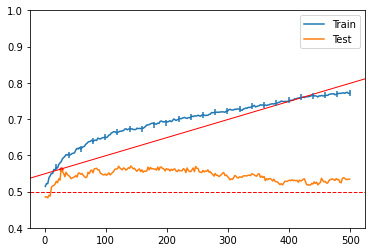

AT (27, 0.562452643235997, 0.36083788541120243) WITH 25 ITERATIONS IN 118.05942283357892 SECONDS : 78.80625887776289
__main__.SVM_RFE_W_STEP - 00:02:23.402700900
poly 0.9 1 1.0


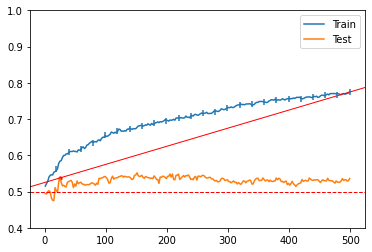

AT (25, 0.5375551281304035, 0.3799558974956772) WITH 25 ITERATIONS IN 118.23914912768772 SECONDS : 57.505601989138654
__main__.SVM_RFE_W_STEP - 00:02:21.454308100
poly 0.1 2 1.0


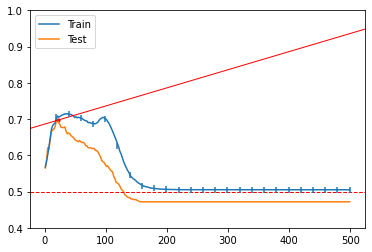

AT (21, 0.6967224262205903, 0.25102205902352775) WITH 25 ITERATIONS IN 135.4611199583326 SECONDS : 60.574486058302945
__main__.SVM_RFE_W_STEP - 00:02:37.383853100
poly 0.2 2 1.0


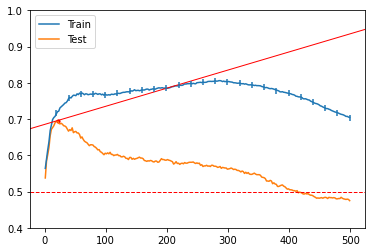

AT (21, 0.6958481475005343, 0.2517214819995726) WITH 25 ITERATIONS IN 133.89161579949516 SECONDS : 66.00782469878446
__main__.SVM_RFE_W_STEP - 00:02:37.650402300
poly 0.3 2 1.0


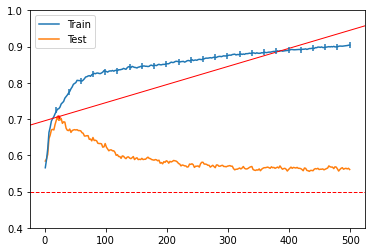

AT (21, 0.7058100678051719, 0.2437519457558625) WITH 25 ITERATIONS IN 132.0201427255358 SECONDS : 57.107302146522784
__main__.SVM_RFE_W_STEP - 00:02:34.406347800
poly 0.4 2 1.0


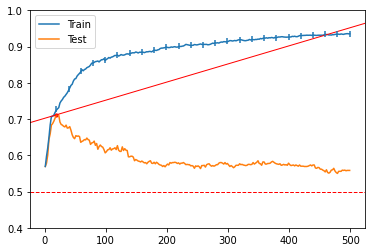

AT (19, 0.7117017349575488, 0.23823861203396093) WITH 25 ITERATIONS IN 131.11613573346818 SECONDS : 53.338827357898076
__main__.SVM_RFE_W_STEP - 00:02:33.583903500
poly 0.5 2 1.0


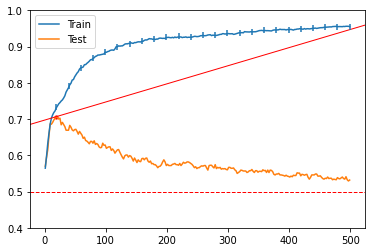

AT (19, 0.7067329175652308, 0.24221366594781535) WITH 25 ITERATIONS IN 129.5704849106925 SECONDS : 61.12971908370967
__main__.SVM_RFE_W_STEP - 00:02:33.325372100
poly 0.6 2 1.0


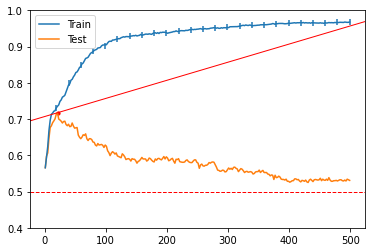

AT (21, 0.7175205455499213, 0.23438356356006299) WITH 25 ITERATIONS IN 128.21701053210668 SECONDS : 69.45476218511735
__main__.SVM_RFE_W_STEP - 00:02:33.120971800
poly 0.7 2 1.0


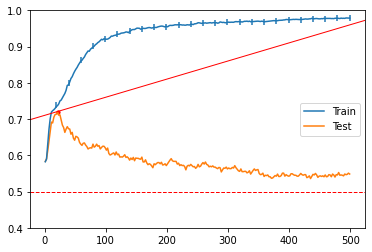

AT (21, 0.720828233374133, 0.23173741330069356) WITH 25 ITERATIONS IN 128.71105074882507 SECONDS : 66.26565013821092
__main__.SVM_RFE_W_STEP - 00:02:34.291978900
poly 0.8 2 1.0


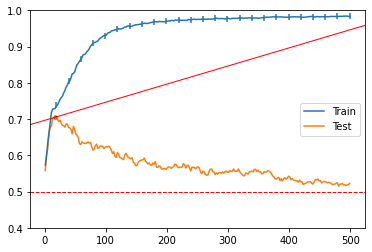

AT (17, 0.7050280740611219, 0.2427775407511025) WITH 25 ITERATIONS IN 127.65578607150486 SECONDS : 58.97767692803051
__main__.SVM_RFE_W_STEP - 00:02:34.442008600
poly 0.9 2 1.0


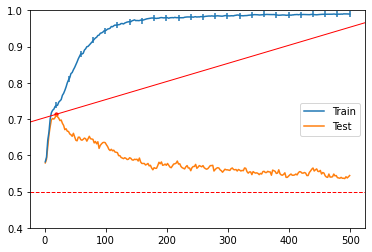

AT (19, 0.7133142934856522, 0.23694856521147822) WITH 25 ITERATIONS IN 127.492077929633 SECONDS : 74.07395068191286
__main__.SVM_RFE_W_STEP - 00:02:35.077494000
poly 0.1 3 1.0


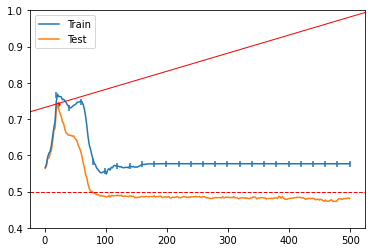

AT (21, 0.7425589166715237, 0.214352866662781) WITH 25 ITERATIONS IN 138.933472769601 SECONDS : 64.78501584904625
__main__.SVM_RFE_W_STEP - 00:02:54.032412800
poly 0.2 3 1.0


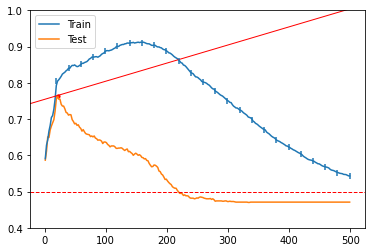

AT (21, 0.7650181655689611, 0.19638546754483113) WITH 25 ITERATIONS IN 136.45180763517106 SECONDS : 41.637253602315276
__main__.SVM_RFE_W_STEP - 00:02:49.244537200
poly 0.3 3 1.0


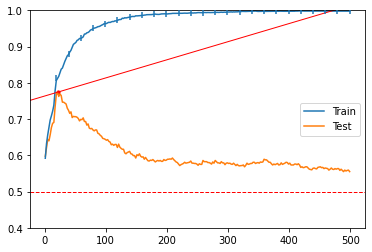

AT (21, 0.774125235569544, 0.18909981154436475) WITH 25 ITERATIONS IN 146.44586532456535 SECONDS : 62.76453603813058
__main__.SVM_RFE_W_STEP - 00:03:01.463621900
poly 0.4 3 1.0


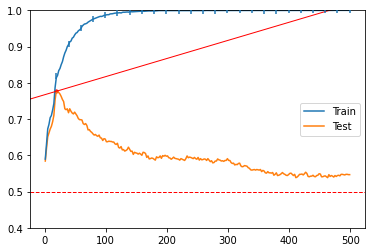

AT (19, 0.776704357793709, 0.18623651376503275) WITH 25 ITERATIONS IN 143.3227528844561 SECONDS : 43.70244829752232
__main__.SVM_RFE_W_STEP - 00:02:59.474825600
poly 0.5 3 1.0


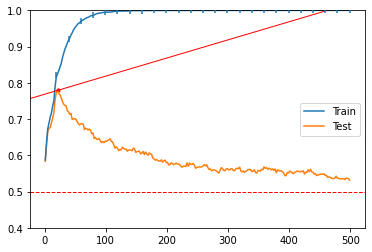

AT (21, 0.7790891958578617, 0.18512864331371062) WITH 25 ITERATIONS IN 141.12244854654585 SECONDS : 48.45981567509359
__main__.SVM_RFE_W_STEP - 00:02:58.876635500
poly 0.6 3 1.0


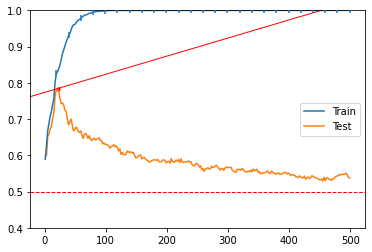

AT (21, 0.7841842979541879, 0.1810525616366497) WITH 25 ITERATIONS IN 139.54762063707625 SECONDS : 56.916869803237354
__main__.SVM_RFE_W_STEP - 00:02:57.512357700
poly 0.7 3 1.0


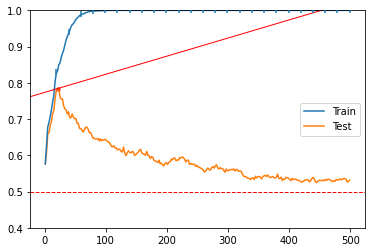

AT (21, 0.7841502982261855, 0.18107976141905158) WITH 25 ITERATIONS IN 139.65196200779505 SECONDS : 48.949401833671644
__main__.SVM_RFE_W_STEP - 00:02:56.102613200
poly 0.8 3 1.0


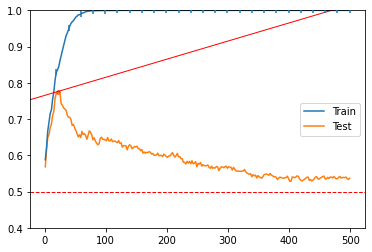

AT (21, 0.7758592216976549, 0.1877126226418761) WITH 25 ITERATIONS IN 136.62208880696977 SECONDS : 66.11513381375963
__main__.SVM_RFE_W_STEP - 00:02:55.589058300
poly 0.9 3 1.0


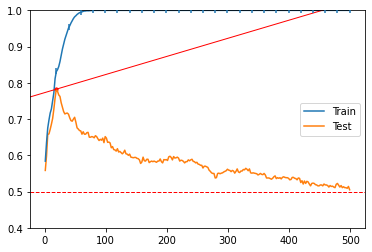

AT (19, 0.7825183112820813, 0.18158535097433498) WITH 25 ITERATIONS IN 143.23912024497986 SECONDS : 56.351725714549744
__main__.SVM_RFE_W_STEP - 00:03:02.332157300
poly 0.1 4 1.0


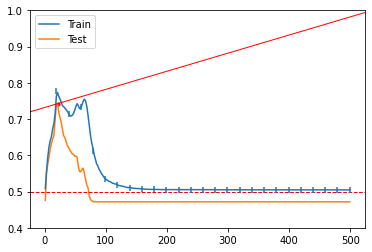

AT (21, 0.7424714887995182, 0.21442280896038546) WITH 25 ITERATIONS IN 149.04622220993042 SECONDS : 43.24774089008152
__main__.SVM_RFE_W_STEP - 00:03:03.513764500
poly 0.2 4 1.0


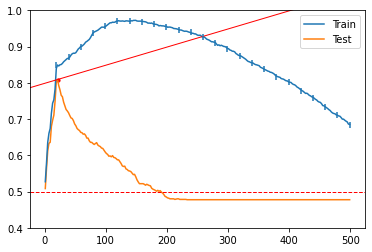

AT (21, 0.8091449554117852, 0.16108403567057183) WITH 25 ITERATIONS IN 151.96627238818579 SECONDS : 41.082348365209306
__main__.SVM_RFE_W_STEP - 00:03:04.099369100
poly 0.3 4 1.0


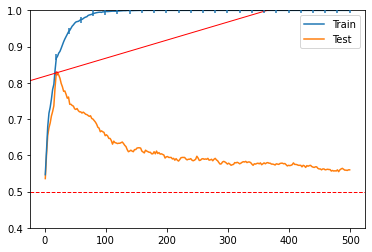

AT (19, 0.8274513803889569, 0.14563889568883445) WITH 25 ITERATIONS IN 127.23231887817383 SECONDS : 43.49730929213256
__main__.SVM_RFE_W_STEP - 00:02:39.661951500
poly 0.4 4 1.0


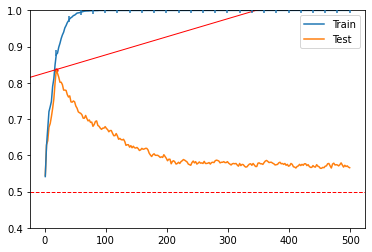

AT (19, 0.836670163781547, 0.1382638689747624) WITH 25 ITERATIONS IN 126.5187635421753 SECONDS : 56.31292472220444
__main__.SVM_RFE_W_STEP - 00:02:38.215927000
poly 0.5 4 1.0


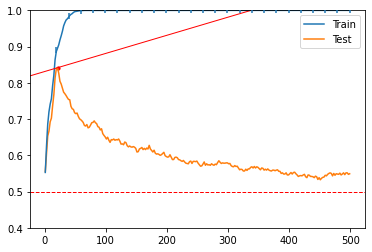

AT (21, 0.8417361232538713, 0.13501110139690298) WITH 25 ITERATIONS IN 130.23603783335005 SECONDS : 55.66095266142823
__main__.SVM_RFE_W_STEP - 00:02:44.127867800
poly 0.6 4 1.0


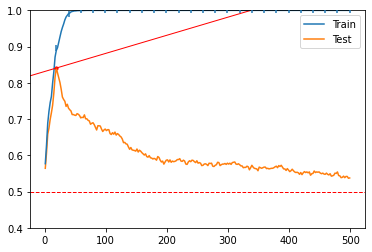

AT (19, 0.8408327019098133, 0.13493383847214938) WITH 25 ITERATIONS IN 129.77829796927315 SECONDS : 52.48473336086359
__main__.SVM_RFE_W_STEP - 00:02:43.308276700
poly 0.7 4 1.0


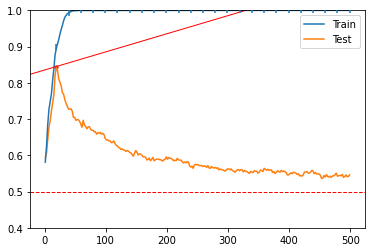

AT (19, 0.8449903829340795, 0.13160769365273645) WITH 25 ITERATIONS IN 132.56959268024988 SECONDS : 76.65946988706014
__main__.SVM_RFE_W_STEP - 00:02:46.720135000
poly 0.8 4 1.0


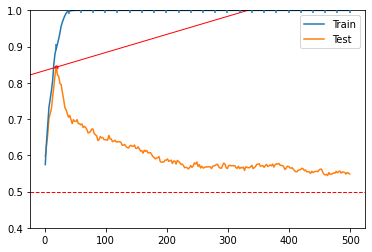

AT (19, 0.8433195391579725, 0.13294436867362197) WITH 25 ITERATIONS IN 133.48417340006148 SECONDS : 61.41692332120716
__main__.SVM_RFE_W_STEP - 00:02:48.153782700
poly 0.9 4 1.0


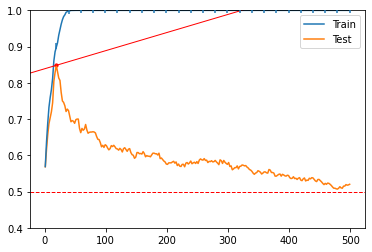

AT (19, 0.8483563560062947, 0.12891491519496429) WITH 25 ITERATIONS IN 131.4725650038038 SECONDS : 35.43784452031614
__main__.SVM_RFE_W_STEP - 00:02:44.754963500
poly 0.1 5 1.0


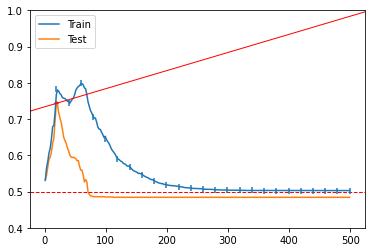

AT (19, 0.7433651959355753, 0.2129078432515398) WITH 25 ITERATIONS IN 134.42569623674666 SECONDS : 76.2662276901086
__main__.SVM_RFE_W_STEP - 00:02:46.191044100
poly 0.2 5 1.0


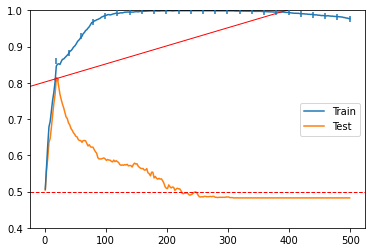

AT (19, 0.8116463639719453, 0.15828290882244372) WITH 25 ITERATIONS IN 134.78731451715743 SECONDS : 52.37267649589934
__main__.SVM_RFE_W_STEP - 00:02:47.679282300
poly 0.3 5 1.0


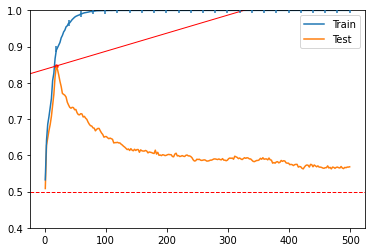

AT (19, 0.8465932272541821, 0.13032541819665436) WITH 25 ITERATIONS IN 134.88612971987044 SECONDS : 71.56987308597802
__main__.SVM_RFE_W_STEP - 00:02:48.749280900
poly 0.4 5 1.0


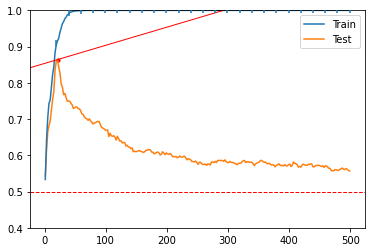

AT (21, 0.8641565153193059, 0.11707478774455526) WITH 25 ITERATIONS IN 134.51800867489405 SECONDS : 38.47280066104821
__main__.SVM_RFE_W_STEP - 00:02:46.484994700
poly 0.5 5 1.0


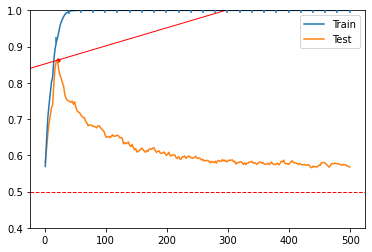

AT (21, 0.8625002428552, 0.11839980571584001) WITH 25 ITERATIONS IN 136.19941108567374 SECONDS : 60.2833601034528
__main__.SVM_RFE_W_STEP - 00:02:50.057569500
poly 0.6 5 1.0


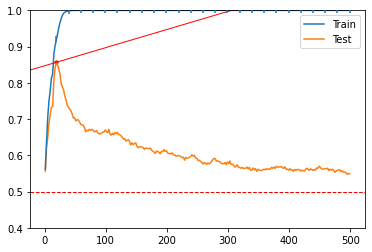

AT (19, 0.8567008606788288, 0.12223931145693698) WITH 25 ITERATIONS IN 135.4553942680359 SECONDS : 49.99600283887456
__main__.SVM_RFE_W_STEP - 00:02:50.415836500
poly 0.7 5 1.0


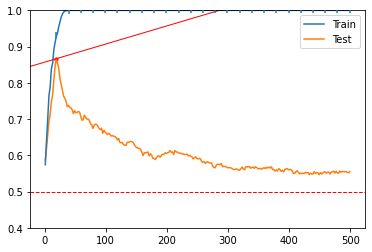

AT (19, 0.8666530667754658, 0.11427754657962734) WITH 25 ITERATIONS IN 133.9435816492353 SECONDS : 63.838923508519194
__main__.SVM_RFE_W_STEP - 00:02:47.892365800
poly 0.8 5 1.0


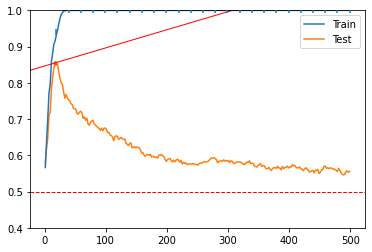

AT (17, 0.8550057313827205, 0.12279541489382359) WITH 25 ITERATIONS IN 134.48225167819433 SECONDS : 72.53078550140708
__main__.SVM_RFE_W_STEP - 00:02:48.851043700
poly 0.9 5 1.0


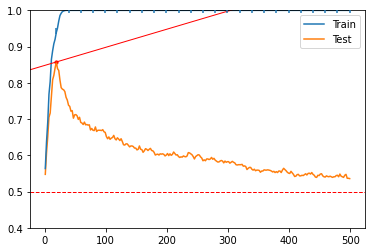

AT (19, 0.8575557109828836, 0.1215554312136931) WITH 25 ITERATIONS IN 135.06272128650122 SECONDS : 66.6991003012636
__main__.SVM_RFE_W_STEP - 00:02:50.422835400
poly 0.1 6 1.0


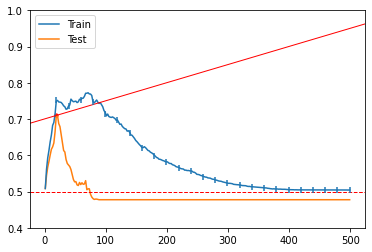

AT (19, 0.7100211769734414, 0.2395830584212469) WITH 25 ITERATIONS IN 135.98046163150244 SECONDS : 78.20575864189742
__main__.SVM_RFE_W_STEP - 00:02:48.183307300
poly 0.2 6 1.0


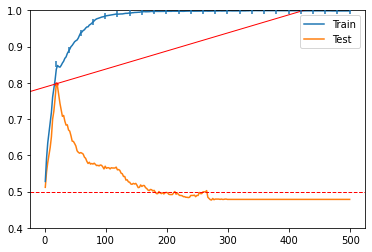

AT (19, 0.7974684773950379, 0.1696252180839697) WITH 25 ITERATIONS IN 133.15699594361442 SECONDS : 66.04918552721848
__main__.SVM_RFE_W_STEP - 00:02:45.258197600
poly 0.3 6 1.0


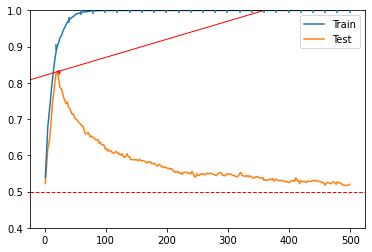

AT (21, 0.8308464960851741, 0.1437228031318607) WITH 25 ITERATIONS IN 135.83634178979057 SECONDS : 43.92078270107037
__main__.SVM_RFE_W_STEP - 00:02:48.548532300
poly 0.4 6 1.0


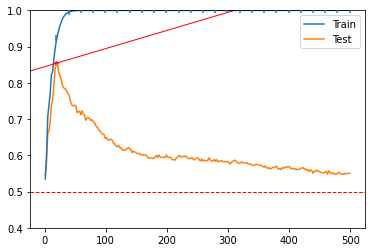

AT (19, 0.854126595558664, 0.12429872355306881) WITH 25 ITERATIONS IN 137.36209971564156 SECONDS : 54.08757517033539
__main__.SVM_RFE_W_STEP - 00:02:50.693745500
poly 0.5 6 1.0


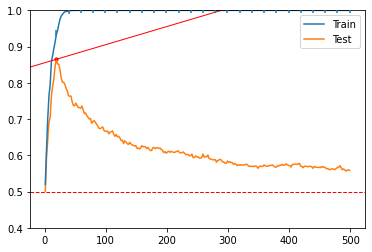

AT (19, 0.8649336519593557, 0.11565307843251546) WITH 25 ITERATIONS IN 135.47558631215776 SECONDS : 67.72435304202153
__main__.SVM_RFE_W_STEP - 00:02:49.547267700
poly 0.6 6 1.0


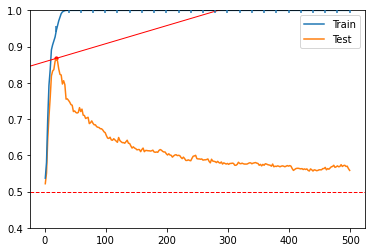

AT (19, 0.8675516310155231, 0.1135586951875815) WITH 25 ITERATIONS IN 136.94240280560084 SECONDS : 59.65677949511037
__main__.SVM_RFE_W_STEP - 00:02:50.906515900
poly 0.7 6 1.0


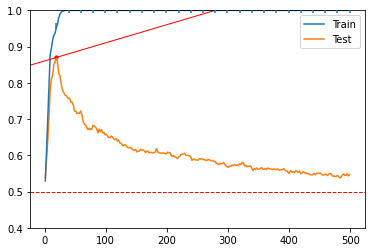

AT (19, 0.8700093256396804, 0.1115925394882557) WITH 25 ITERATIONS IN 134.9410515172141 SECONDS : 77.92849574839113
__main__.SVM_RFE_W_STEP - 00:02:48.899796600
poly 0.8 6 1.0


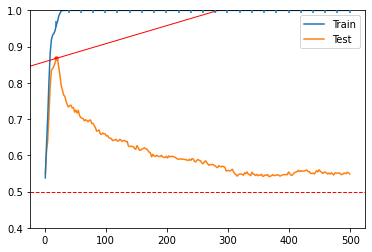

AT (19, 0.8675224883915214, 0.11358200928678291) WITH 25 ITERATIONS IN 137.60242710794722 SECONDS : 48.218756668573484
__main__.SVM_RFE_W_STEP - 00:02:50.576943400
poly 0.9 6 1.0


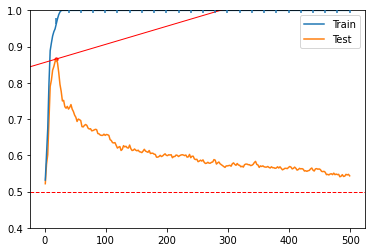

AT (19, 0.8658030735754114, 0.11495754113967087) WITH 25 ITERATIONS IN 133.58426349503654 SECONDS : 67.98764134677239
__main__.SVM_RFE_W_STEP - 00:02:49.166191100
poly 0.1 7 1.0


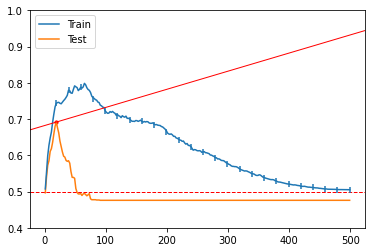

AT (19, 0.6917244662042704, 0.2542204270365837) WITH 25 ITERATIONS IN 135.81818318367004 SECONDS : 57.14649875992307
__main__.SVM_RFE_W_STEP - 00:02:47.782251300
poly 0.2 7 1.0


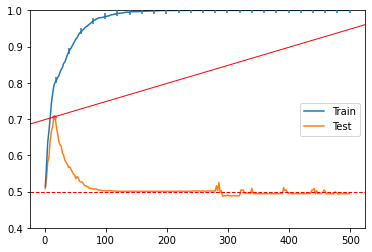

AT (15, 0.705844067533174, 0.24132474597346085) WITH 25 ITERATIONS IN 131.56621398244584 SECONDS : 44.02838025888069
__main__.SVM_RFE_W_STEP - 00:02:43.860927900
poly 0.3 7 1.0


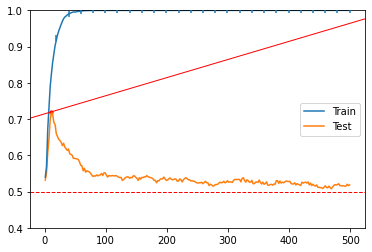

AT (11, 0.7200122399020809, 0.22839020807833532) WITH 25 ITERATIONS IN 136.64622521400452 SECONDS : 56.0728686725879
__main__.SVM_RFE_W_STEP - 00:02:50.061940400
poly 0.4 7 1.0


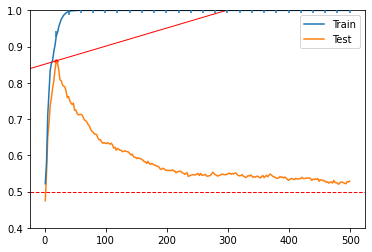

AT (19, 0.8608536845990946, 0.1189170523207243) WITH 25 ITERATIONS IN 133.19835080419267 SECONDS : 70.72844800096684
__main__.SVM_RFE_W_STEP - 00:02:49.334026700
poly 0.5 7 1.0


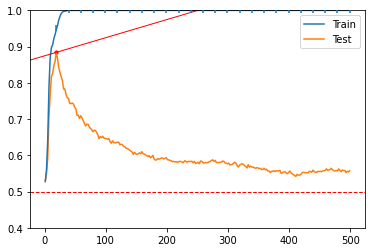

AT (19, 0.8841386411765849, 0.10028908705873207) WITH 25 ITERATIONS IN 128.16862644468034 SECONDS : 59.285510550980625
__main__.SVM_RFE_W_STEP - 00:02:40.306098400
poly 0.6 7 1.0


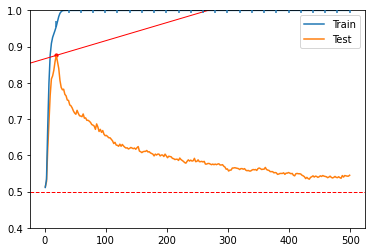

AT (19, 0.8758232791280527, 0.10694137669755785) WITH 25 ITERATIONS IN 125.54278128487724 SECONDS : 42.49102101794791
__main__.SVM_RFE_W_STEP - 00:02:37.203229000
poly 0.7 7 1.0


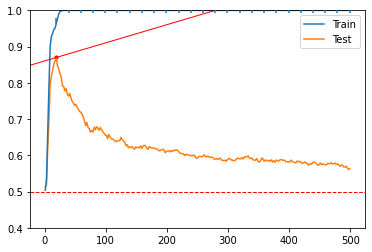

AT (19, 0.86999961143168, 0.11160031085465598) WITH 25 ITERATIONS IN 126.12250593730381 SECONDS : 53.71686922301785
__main__.SVM_RFE_W_STEP - 00:02:38.615969000
poly 0.8 7 1.0


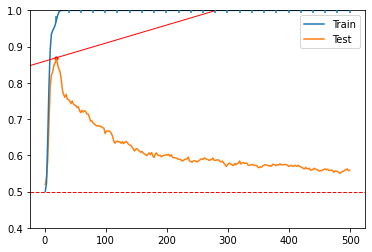

AT (19, 0.8691690466476268, 0.11226476268189853) WITH 25 ITERATIONS IN 125.56143004553658 SECONDS : 48.749690525549006
__main__.SVM_RFE_W_STEP - 00:02:37.051637900
poly 0.9 7 1.0


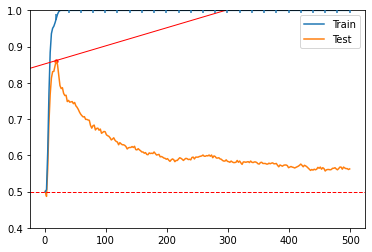

AT (19, 0.8616405354471449, 0.11828757164228407) WITH 25 ITERATIONS IN 126.23843097686768 SECONDS : 48.334390116776554
__main__.SVM_RFE_W_STEP - 00:02:38.529683800
poly 0.1 8 1.0


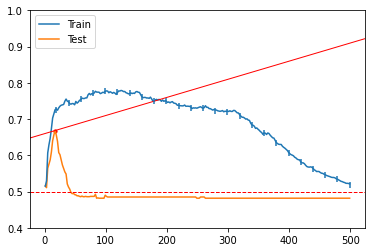

AT (17, 0.6683569388587749, 0.2721144489129801) WITH 25 ITERATIONS IN 138.7598286015647 SECONDS : 34.21517312078097
__main__.SVM_RFE_W_STEP - 00:02:50.304764100
poly 0.2 8 1.0


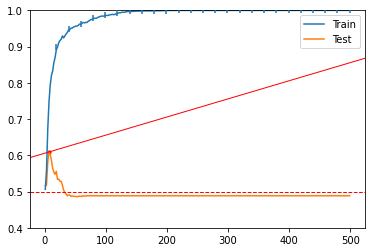

AT (7, 0.6092508402789921, 0.31539932777680635) WITH 25 ITERATIONS IN 143.66923999786377 SECONDS : 57.475165056451615
__main__.SVM_RFE_W_STEP - 00:02:55.566894900
poly 0.3 8 1.0


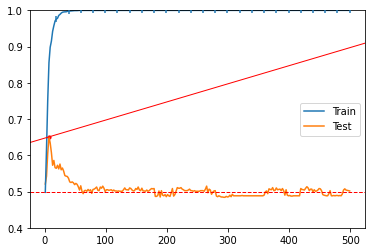

AT (7, 0.6509102212896583, 0.28207182296827343) WITH 25 ITERATIONS IN 130.71920684405737 SECONDS : 46.26412645664216
__main__.SVM_RFE_W_STEP - 00:02:42.756670500
poly 0.4 8 1.0


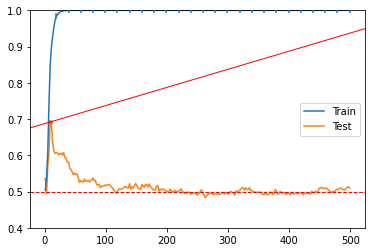

AT (9, 0.6919430358842844, 0.2500455712925725) WITH 25 ITERATIONS IN 130.23499645505632 SECONDS : 34.91099387242925
__main__.SVM_RFE_W_STEP - 00:02:41.913133300
poly 0.5 8 1.0


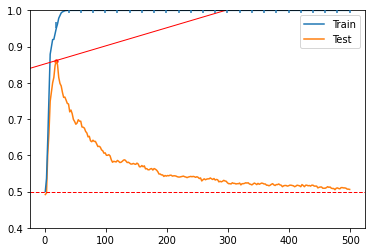

AT (19, 0.8615968215111421, 0.11832254279108628) WITH 25 ITERATIONS IN 128.8565719468253 SECONDS : 32.547432623381475
__main__.SVM_RFE_W_STEP - 00:02:41.033579900
poly 0.6 8 1.0


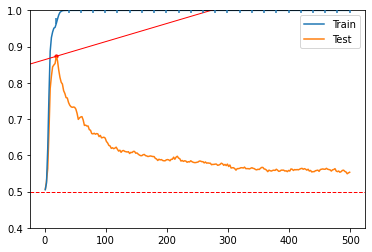

AT (19, 0.8733558702958948, 0.10891530376328418) WITH 25 ITERATIONS IN 129.79714403833663 SECONDS : 58.545367499946344
__main__.SVM_RFE_W_STEP - 00:02:42.348967600
poly 0.7 8 1.0


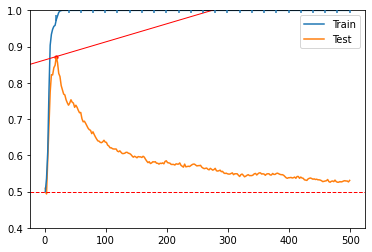

AT (19, 0.8725544481358434, 0.1095564414913253) WITH 25 ITERATIONS IN 128.9718998840877 SECONDS : 47.895540302048
__main__.SVM_RFE_W_STEP - 00:02:40.968551300
poly 0.8 8 1.0


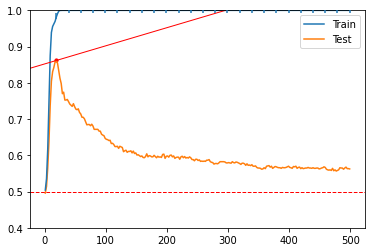

AT (19, 0.8617036777991489, 0.11823705776068087) WITH 25 ITERATIONS IN 129.0276823725019 SECONDS : 35.04949327002758
__main__.SVM_RFE_W_STEP - 00:02:41.489777600
poly 0.9 8 1.0


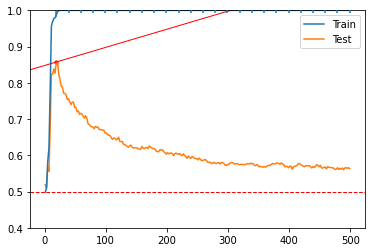

AT (19, 0.8574634260068777, 0.1216292591944978) WITH 25 ITERATIONS IN 134.34448449952262 SECONDS : 38.62257553667871
__main__.SVM_RFE_W_STEP - 00:02:46.731845400
poly 0.1 9 1.0


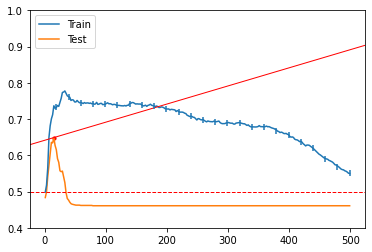

AT (15, 0.6489868081055352, 0.28681055351557183) WITH 25 ITERATIONS IN 130.9560488632747 SECONDS : 56.10990738305871
__main__.SVM_RFE_W_STEP - 00:02:41.526548500
poly 0.2 9 1.0


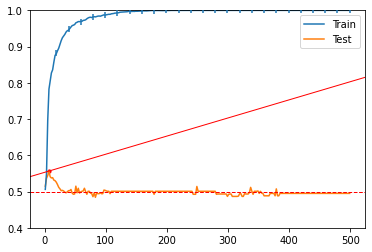

AT (7, 0.556609547123623, 0.35751236230110167) WITH 25 ITERATIONS IN 136.99709115709578 SECONDS : 50.98103370595379
__main__.SVM_RFE_W_STEP - 00:02:50.542633700
poly 0.3 9 1.0


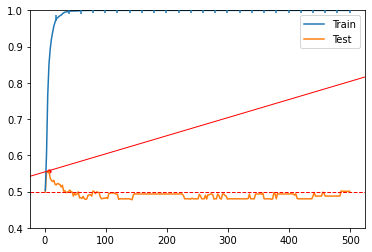

AT (7, 0.5576392531716889, 0.3566885974626489) WITH 25 ITERATIONS IN 137.10399900163924 SECONDS : 51.62659605258983
__main__.SVM_RFE_W_STEP - 00:02:51.616844000
poly 0.4 9 1.0


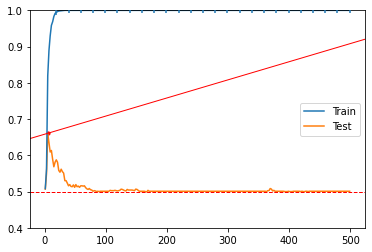

AT (5, 0.6607895708262905, 0.2733683433389676) WITH 25 ITERATIONS IN 137.3344280379159 SECONDS : 60.24717411799958
__main__.SVM_RFE_W_STEP - 00:02:51.563658400
poly 0.5 9 1.0


AT (7, 0.6667783800586738, 0.269377295953061) WITH 25 ITERATIONS IN 137.8461069038936 SECONDS : 80.06555122519714
__main__.SVM_RFE_W_STEP - 00:02:52.476601500
poly 0.6 9 1.0


AT (17, 0.8208165763245324, 0.15014673894037406) WITH 25 ITERATIONS IN 130.91081483023507 SECONDS : 42.60446668884798
__main__.SVM_RFE_W_STEP - 00:02:42.929126600
poly 0.7 9 1.0


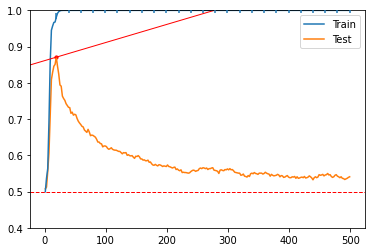

AT (19, 0.8708350333197334, 0.11093197334421324) WITH 25 ITERATIONS IN 128.11532276017326 SECONDS : 47.831918065921975
__main__.SVM_RFE_W_STEP - 00:02:40.536140500
poly 0.8 9 1.0


AT (19, 0.8591828408229877, 0.12025372734160986) WITH 25 ITERATIONS IN 125.73001868384225 SECONDS : 35.67367403710581
__main__.SVM_RFE_W_STEP - 00:02:36.666720800
poly 0.9 9 1.0


AT (19, 0.8574925686308795, 0.12160594509529637) WITH 25 ITERATIONS IN 121.53428976876395 SECONDS : 29.913457077532396
__main__.SVM_RFE_W_STEP - 00:02:31.519939800


In [9]:
model_selection = {}
for d in [1, 2, 3, 4, 5, 6, 7, 8, 9]:
    for C in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        model_selection[C, d] = SVM_RFE_W_STEP(kernel='poly', degree=d, C=C)

In [19]:
lines = {}
for C, d in model_selection:
    lines[C] = ['\\textbf{' + "{:.1f}".format(C) + '}', '', '', '']

for C, d in model_selection:
    col = {7: 1, 8: 2, 9: 3}
    if d in col.keys():
        v = model_selection[C, d]
        lines[C][col[d]] = "  {:>3s} & {:.2f}\\% & {:.3f} $\\pm$ {:.3f}".format(str(v[0][0]), 100 * v[0][1], v[2][0], v[2][1])

for line in lines.values():
    print(' & '.join(line) + '\\\\')

\textbf{0.1} &    19 & 69.17\% & 0.240 $\pm$ 0.011 &    17 & 66.84\% & 0.258 $\pm$ 0.010 &    15 & 64.90\% & 0.261 $\pm$ 0.025\\
\textbf{0.2} &    15 & 70.58\% & 0.218 $\pm$ 0.009 &     7 & 60.93\% & 0.295 $\pm$ 0.026 &     7 & 55.66\% & 0.332 $\pm$ 0.011\\
\textbf{0.3} &    11 & 72.00\% & 0.205 $\pm$ 0.022 &     7 & 65.09\% & 0.265 $\pm$ 0.031 &     7 & 55.76\% & 0.321 $\pm$ 0.018\\
\textbf{0.4} &    19 & 86.09\% & 0.116 $\pm$ 0.005 &     9 & 69.19\% & 0.232 $\pm$ 0.032 &     5 & 66.08\% & 0.262 $\pm$ 0.018\\
\textbf{0.5} &    19 & 88.41\% & 0.100 $\pm$ 0.004 &    19 & 86.16\% & 0.113 $\pm$ 0.011 &     7 & 66.68\% & 0.240 $\pm$ 0.014\\
\textbf{0.6} &    19 & 87.58\% & 0.106 $\pm$ 0.005 &    19 & 87.34\% & 0.104 $\pm$ 0.006 &    17 & 82.08\% & 0.129 $\pm$ 0.013\\
\textbf{0.7} &    19 & 87.00\% & 0.104 $\pm$ 0.007 &    19 & 87.26\% & 0.107 $\pm$ 0.007 &    19 & 87.08\% & 0.107 $\pm$ 0.010\\
\textbf{0.8} &    19 & 86.92\% & 0.106 $\pm$ 0.004 &    19 & 86.17\% & 0.109 $\pm$ 0.008 &    19 

In [14]:
lines = {}
for C, d in model_selection:
    lines[C] = ['\\textbf{' + "{:.1f}".format(C) + '}', '', '', '', '', '', '', '', '', '']

for C, d in model_selection:
    col = {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}
    if d in col.keys():
        v = model_selection[C, d]
        lines[C][col[d]] = "{:.0f}:{:0>2s}.{:0>2s}".format(math.floor(v[1]/60.0), str(int(v[1] % 60)), str(int((v[1] % 1) * 100)))

for line in lines.values():
    print(' & '.join(line) + '\\\\')

\textbf{0.1} & 2:07.89 & 2:15.46 & 2:18.93 & 2:29.04 & 2:14.42 & 2:15.98 & 2:15.81 & 2:18.75 & 2:10.95\\
\textbf{0.2} & 2:10.60 & 2:13.89 & 2:16.45 & 2:31.96 & 2:14.78 & 2:13.15 & 2:11.56 & 2:23.66 & 2:16.99\\
\textbf{0.3} & 2:07.25 & 2:12.02 & 2:26.44 & 2:07.23 & 2:14.88 & 2:15.83 & 2:16.64 & 2:10.71 & 2:17.10\\
\textbf{0.4} & 2:04.60 & 2:11.11 & 2:23.32 & 2:06.51 & 2:14.51 & 2:17.36 & 2:13.19 & 2:10.23 & 2:17.33\\
\textbf{0.5} & 2:02.99 & 2:09.57 & 2:21.12 & 2:10.23 & 2:16.19 & 2:15.47 & 2:08.16 & 2:08.85 & 2:17.84\\
\textbf{0.6} & 2:04.20 & 2:08.21 & 2:19.54 & 2:09.77 & 2:15.45 & 2:16.94 & 2:05.54 & 2:09.79 & 2:10.91\\
\textbf{0.7} & 2:05.94 & 2:08.71 & 2:19.65 & 2:12.56 & 2:13.94 & 2:14.94 & 2:06.12 & 2:08.97 & 2:08.11\\
\textbf{0.8} & 1:58.05 & 2:07.65 & 2:16.62 & 2:13.48 & 2:14.48 & 2:17.60 & 2:05.56 & 2:09.02 & 2:05.73\\
\textbf{0.9} & 1:58.23 & 2:07.49 & 2:23.23 & 2:11.47 & 2:15.06 & 2:13.58 & 2:06.23 & 2:14.34 & 2:01.53\\


In [12]:
with open('dump2.pickle', 'wb') as filehandler:
    pickle.dump(model_selection, filehandler)